In [33]:
import librosa
import numpy as np
import pandas as pd
import math
import os
import IPython.display as ipd
import pandas as pd

## Dataset folders
data_root = "/homes/alb30/datasets/"
smt_guitar_root = data_root + "IDMT-SMT-GUITAR/"
guitarset_root = data_root + "GuitarSet/"
gpt_root = data_root + "GuitarPlayingTechniques/"

In [34]:
from src.data_preparation import SMTGuitar 
smt_guitar = SMTGuitar(data_root)

In [35]:
data_loaded = smt_guitar.load_data(path='data/')
print(data_loaded[0])
print(data_loaded[1])

Data loaded successfully
True
                 name  lick   mono guitar excitation expression  position  \
0        AR_Lick10_FN    10  False     AR         FS         NO         0   
1        AR_Lick10_KN    10  False     AR         MU         NO         0   
2        AR_Lick10_MN    10  False     AR         PK         NO         0   
3        AR_Lick11_FN    11   True     AR         FS         NO         0   
4        AR_Lick11_KN    11   True     AR         MU         NO         0   
..                ...   ...    ...    ...        ...        ...       ...   
193  LP_Lick9_FN_Lage     9  False     LP         FS         NO         1   
194       LP_Lick9_KN     9  False     LP         MU         NO         0   
195  LP_Lick9_KN_Lage     9  False     LP         MU         NO         1   
196       LP_Lick9_MN     9  False     LP         PK         NO         0   
197  LP_Lick9_MN_Lage     9  False     LP         PK         NO         1   

        fs      len            ms  \
0    441

In [36]:
if not data_loaded[0]:
    smt_guitar.extract_audio()
    smt_guitar.extract_annotations()
    smt_guitar.extract_transcript()

In [37]:
if not data_loaded[0]:
    smt_guitar.get_simple_transcript()
    smt_guitar.save_data(path='data/')

Number of mono clips: 135


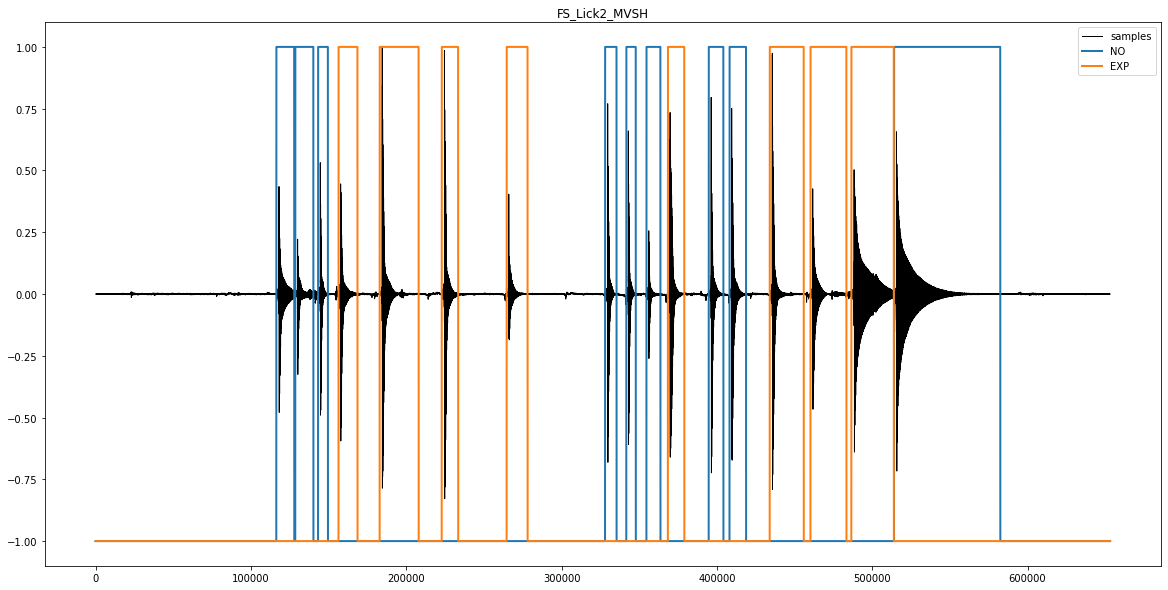

In [38]:
from random import randint
mono_clips = smt_guitar.filter_by({'mono': True})
print("Number of mono clips:", len(mono_clips))
link = mono_clips.sample(n=1) 
idx = link.index[0]
smt_guitar.plot_annotations(idx=idx, simple=True)
ipd.Audio(**smt_guitar.play_data(idx=idx))

In [39]:
bend = smt_guitar.filter_by({'expression': 'BE'})
slide = smt_guitar.filter_by({'expression': 'SL'})
bend_and_slide = pd.concat([bend, slide], axis=1, join='inner')

mono_licks = smt_guitar.filter_by({'mono': True})

import random
el = random.randint(0,len(mono_licks.index))
lick = smt_guitar.get_by_order(el=el, df=mono_licks)
ipd.Audio(**smt_guitar.play_data(idx=lick.name))

In [40]:
idx = 4
array = np.where(smt_guitar.df['transcript'][idx]==1)[0]

# array.unique()
unique_array = np.unique(array)
exp_array = np.array(list(smt_guitar.styles['expression']))
print(exp_array[unique_array], smt_guitar.df['num_exp'][idx])
exp_in_trans = list({key:value for (key,value) in smt_guitar.df['num_exp'][idx].items() if value != 0}.keys())
print(exp_in_trans)

print(set(exp_array[unique_array])==set(exp_in_trans))


['NO' 'BE' 'HA' 'SL' 'VI'] {'NO': 44, 'BE': 13, 'DN': 0, 'HA': 3, 'SL': 2, 'VI': 5}
['NO', 'BE', 'HA', 'SL', 'VI']
True


In [41]:
mono_clips = smt_guitar.filter_by({'mono': True})
print(len(mono_clips))

135


In [42]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
from src.feature_extraction import compute_mel_spectrograms 
import src.utils as utils 
mono_df = smt_guitar.filter_by({'mono': True})
mono_mel_spec_pkl = 'mono_mel_spec.pkl'

# Extract mel spectrograms
mel_loaded, mel_spectrograms = utils.load_dataframe(mono_mel_spec_pkl, path='data/')
# mel_loaded = False
if not mel_loaded:
    print('Compute Mel spectrograms')
    mel_spectrograms = compute_mel_spectrograms(mono_df)
    mel_spectrograms.to_pickle('data/'+mono_mel_spec_pkl)


Data loaded successfully


In [44]:
from src.data_preparation import get_clip_labels 

label_dataframe = get_clip_labels(mono_df, exp=smt_guitar.styles['expression'])

In [45]:
one_hot_labels = np.vstack(label_dataframe['one_hot'].values)
label_encoding = []
for row in one_hot_labels:
    label_encoding.append(pd.DataFrame(row))
print(len(label_encoding))
print(label_encoding[0])

135
   0
0  1
1  1
2  0
3  1
4  1
5  1


In [46]:
from src.feature_extraction import zero_pad_spectrograms 

spectrograms = zero_pad_spectrograms(mel_spectrograms)

In [47]:
print(len(spectrograms))
# print(spectrograms[0]['spectrogram'].values)
print(type(spectrograms[0].values), spectrograms[0].values.shape)
print(type(spectrograms[0].values[0][0]), spectrograms[0].values[0][0].shape)

6
<class 'numpy.ndarray'> (135, 1)
<class 'numpy.ndarray'> (782, 128)


In [48]:
from sklearn.model_selection import train_test_split

## Create train and test sets
train_sets = list()
test_sets = list()

X_train, X_test, y_train, y_test = train_test_split(spectrograms[0], np.array(one_hot_labels))

train_sets.append(X_train)
test_sets.append(X_test)

test_indices = X_train.index
train_indices = X_test.index

for spec in spectrograms[1:]:
        train_sets.append(pd.DataFrame(spec, index=train_indices))
        test_sets.append(pd.DataFrame(spec, index=test_indices))

print(len(train_sets))
print(train_sets[0])

# n_features = X_train.shape[2]
# n_time = X_train.shape[1]
print('Num features', X_train.values[0][0].shape[1])
print('Num frames', X_train.values[0][0].shape[0])

6
                                                     0
85   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
65   [[0.009234574, 0.0047119535, 3.886147e-05, 0.0...
55   [[0.0015714928, 0.0012343653, 0.00089998264, 0...
133  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
115  [[0.0, 6.7949063e-06, 1.394739e-05, 8.344647e-...
..                                                 ...
72   [[0.00012730742, 0.00010477948, 8.284702e-05, ...
39   [[3.218599e-05, 0.00012170528, 0.000216699, 1....
96   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
24   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
60   [[0.001402229, 0.00079349976, 0.00016914368, 0...

[101 rows x 1 columns]
Num features 128
Num frames 782


In [49]:
from sklearn.preprocessing import StandardScaler

def standardize(feat, scaler=None):
    if scaler is None:
        scaler = StandardScaler().fit(feat)
    out = scaler.transform(feat)
    return out, scaler


In [50]:
# Weights for balancing classes
n_samples = one_hot_labels.shape[0]
n_classes = one_hot_labels.shape[1]
weights = n_samples / (n_classes * np.sum(one_hot_labels, axis=0))
print(weights)

[0.16666667 0.5        0.83333333 0.625      0.5        0.5       ]


In [51]:
import tensorflow as tf

from keras.models import Sequential, Model
from keras.layers import Input

In [52]:
n_features = X_train.values[0][0].shape[1]
n_frames = X_train.values[0][0].shape[0]
input_shape = (n_frames, n_features, 1)
# print('Num features', n_features)
# print('Num frames', n_time
print('Input shape', input_shape)

inputs = []
for i, ts in enumerate(train_sets):
    name = 'input_'+str(i)
    inputs.append(Input(input_shape, name=name))
    

Input shape (782, 128, 1)
